In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install Bio

     |████████████████████████████████| 271 kB 5.2 MB/s 
     |████████████████████████████████| 2.3 MB 67.3 MB/s 


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb


In [4]:
def kmer2seq(kmers):
    """
    Convert kmers to original sequence
    
    Arguments:
    kmers -- str, kmers separated by space.
    
    Returns:
    seq -- str, original sequence.

    """
    kmers_list = kmers.split(" ")
    bases = [kmer[0] for kmer in kmers_list[0:-1]]
    bases.append(kmers_list[-1])
    seq = "".join(bases)
    assert len(seq) == len(kmers_list) + len(kmers_list[0]) - 1
    return seq

In [5]:
def seq2kmer(seq, k):
    """
    Convert original sequence to kmers
    
    Arguments:
    seq -- str, original sequence.
    k -- int, kmer of length k specified.
    
    Returns:
    kmers -- str, kmers separated by space

    """
    kmer = [seq[x:x+k] for x in range(len(seq)+1-k)]
    kmers = " ".join(kmer)
    return kmer

In [6]:
def contiguous_regions(condition, len_thres=5):
    """
    Modified from and credit to: https://stackoverflow.com/a/4495197/3751373
    Finds contiguous True regions of the boolean array "condition". Returns
    a 2D array where the first column is the start index of the region and the
    second column is the end index.

    Arguments:
    condition -- custom conditions to filter/select high attention 
            (list of boolean arrays)
    
    Keyword arguments:
    len_thres -- int, specified minimum length threshold for contiguous region 
        (default 5)

    Returns:
    idx -- Index of contiguous regions in sequence

    """
    
    # Find the indicies of changes in "condition"
    d = np.diff(condition)
    idx, = d.nonzero() 

    # We need to start things after the change in "condition". Therefore, 
    # we'll shift the index by 1 to the right.
    idx += 1

    if condition[0]:
        # If the start of condition is True prepend a 0
        idx = np.r_[0, idx]

    if condition[-1]:
        # If the end of condition is True, append the length of the array
        idx = np.r_[idx, condition.size] # Edit

    # Reshape the result into two columns
    idx.shape = (-1,2)
    
    # eliminate those not satisfying length of threshold
    idx = idx[np.argwhere((idx[:,1]-idx[:,0])>=len_thres).flatten()]
    return idx

In [7]:
def find_high_attention(score, min_len=5, **kwargs):
    """
    With an array of attention scores as input, finds contiguous high attention 
    sub-regions indices having length greater than min_len.
    
    Arguments:
    score -- numpy array of attention scores for a sequence

    Keyword arguments:
    min_len -- int, specified minimum length threshold for contiguous region 
        (default 5)
    **kwargs -- other input arguments:
        cond -- custom conditions to filter/select high attention 
            (list of boolean arrays)
    
    Returns:
    motif_regions -- indices of high attention regions in sequence

    """
    
    cond1 = (score > np.mean(score))
    cond2 = (score > 10*np.min(score))
    cond = [cond1, cond2]
    
    cond = list(map(all, zip(*cond)))
    
    if 'cond' in kwargs: # if input custom conditions, use them
        cond = kwargs['cond']
        if any(isinstance(x, list) for x in cond): # if input contains multiple conditions
            cond = list(map(all, zip(*cond)))
    
    cond = np.asarray(cond)
        

    # find important contiguous region with high attention
    motif_regions = contiguous_regions(cond,min_len)
    
    return motif_regions

In [8]:
def count_motif_instances(seqs, motifs, allow_multi_match=False):
    """
    Use Aho-Corasick algorithm for efficient multi-pattern matching
    between input sequences and motif patterns to obtain counts of instances.
    
    Arguments:
    seqs -- list, numpy array or pandas series of DNA sequences
    motifs -- list, numpy array or pandas series, a collection of motif patterns
        to be matched to seqs

    Keyword arguments:
    allow_multi_match -- bool, whether to allow for counting multiple matchs (default False)

    Returns:
    motif_count -- count of motif instances (int)
    
    """
    import ahocorasick 
    from operator import itemgetter
    
    motif_count = {}
    
    A = ahocorasick.Automaton()
    for idx, key in enumerate(motifs):
        A.add_word(key, (idx, key))
        motif_count[key] = 0
    A.make_automaton()
    
    for seq in seqs:
        matches = sorted(map(itemgetter(1), A.iter(seq)))
        matched_seqs = []
        for match in matches:
            match_seq = match[1]
            assert match_seq in motifs
            if allow_multi_match:
                motif_count[match_seq] += 1
            else: # for a particular seq, count only once if multiple matches were found
                if match_seq not in matched_seqs:
                    motif_count[match_seq] += 1
                    matched_seqs.append(match_seq)
    
    return motif_count

In [9]:
def motifs_hypergeom_test(pos_seqs, neg_seqs, motifs, p_adjust = 'fdr_bh', alpha = 0.05, verbose=False, 
                          allow_multi_match=False, **kwargs):
    """
    Perform hypergeometric test to find significantly enriched motifs in positive sequences.
    Returns a list of adjusted p-values.
    
    Arguments:
    pos_seqs -- list, numpy array or pandas series of positive DNA sequences
    neg_seqs -- list, numpy array or pandas series of negative DNA sequences
    motifs -- list, numpy array or pandas series, a collection of motif patterns
        to be matched to seqs
    Keyword arguments:
    p_adjust -- method used to correct for multiple testing problem. Options are same as
        statsmodels.stats.multitest (default 'fdr_bh')
    alpha -- cutoff FDR/p-value to declare statistical significance (default 0.05)
    verbose -- verbosity argument (default False)
    allow_multi_match -- bool, whether to allow for counting multiple matchs (default False)
    Returns:
    pvals -- a list of p-values.
    """
    from scipy.stats import hypergeom
    import statsmodels.stats.multitest as multi
    
    
    pvals = []
    N = len(pos_seqs) + len(neg_seqs)
    K = len(pos_seqs)
    motif_count_all = count_motif_instances(pos_seqs+neg_seqs, motifs, allow_multi_match=allow_multi_match)
    motif_count_pos = count_motif_instances(pos_seqs, motifs, allow_multi_match=allow_multi_match)
    
    for motif in motifs:
        n = motif_count_all[motif]
        x = motif_count_pos[motif]
        pval = hypergeom.sf(x-1, N, K, n)
        if verbose:
            if pval < 1e-5:
                print("motif {}: N={}; K={}; n={}; x={}; p={}".format(motif, N, K, n, x, pval))
#         pvals[motif] = pval
        pvals.append(pval)
    
    # adjust p-value
    if p_adjust is not None:
        pvals = list(multi.multipletests(pvals,alpha=alpha,method=p_adjust)[1])
    return pvals

In [10]:
def filter_motifs(pos_seqs, neg_seqs, motifs, cutoff=0.05, return_idx=False, **kwargs):
    """
    Wrapper function for returning the actual motifs that passed the hypergeometric test.
    
    Arguments:
    pos_seqs -- list, numpy array or pandas series of positive DNA sequences
    neg_seqs -- list, numpy array or pandas series of negative DNA sequences
    motifs -- list, numpy array or pandas series, a collection of motif patterns
        to be matched to seqs

    Keyword arguments:
    cutoff -- cutoff FDR/p-value to declare statistical significance. (default 0.05)
    return_idx -- whether the indices of the motifs are only returned. (default False)
    **kwargs -- other input arguments
    
    Returns:
    list of filtered motifs (or indices of the motifs)

    """ 
    pvals = motifs_hypergeom_test(pos_seqs, neg_seqs, motifs, **kwargs)
    if return_idx:
        return [i for i, pval in enumerate(pvals) if pval < cutoff]
    else:
        return [motifs[i] for i, pval in enumerate(pvals) if pval < cutoff]

In [11]:
def merge_motifs(motif_seqs, min_len=5, align_all_ties=True, **kwargs):
    """
    Function to merge similar motifs in input motif_seqs.
    
    First sort keys of input motif_seqs based on length. For each query motif with length
    guaranteed to >= key motif, perform pairwise alignment between them.
    
    If can be aligned, find out best alignment among all combinations, then adjust start
    and end position of high attention region based on left/right offsets calculated by 
    alignment of the query and key motifs.
    
    If cannot be aligned with any existing key motifs, add to the new dict as new key motif.
    
    Returns a new dict containing merged motifs.
    
    Arguments:
    motif_seqs -- nested dict, with the following structure: 
        {motif: {seq_idx: idx, atten_region_pos: (start, end)}}
        where seq_idx indicates indices of pos_seqs containing a motif, and
        atten_region_pos indicates where the high attention region is located.
    
    Keyword arguments:
    min_len -- int, specified minimum length threshold for contiguous region 
        (default 5)
    
    align_all_ties -- bool, whether to keep all best alignments when ties encountered (default True)
    
    **kwargs -- other input arguments, may include:
        - cond: custom condition used to declare successful alignment.
            default is score > max of (min_len -1) and (1/2 times min length of two motifs aligned)
    
    Returns:
    merged_motif_seqs -- nested dict with same structure as `motif_seqs`

    """ 
    
    from Bio import Align
    
    ### TODO: modify algorithm to improve efficiency later
    aligner = Align.PairwiseAligner()
    aligner.internal_gap_score = -10000.0 # prohibit internal gaps
    
    merged_motif_seqs = {}
    for motif in sorted(motif_seqs, key=len): # query motif
        if not merged_motif_seqs: # if empty
            merged_motif_seqs[motif] = motif_seqs[motif] # add first one
        else: # not empty, then compare and see if can be merged
            # first create all alignment scores, to find out max
            alignments = []
            key_motifs = []
            for key_motif in merged_motif_seqs.keys(): # key motif
                if motif != key_motif: # do not attempt to align to self
                    # first is query, second is key within new dict
                    # first is guaranteed to be length >= second after sorting keys
                    alignment=aligner.align(motif, key_motif)[0] 
                    
                    # condition to declare successful alignment
                    cond = max((min_len -1), 0.5 * min(len(motif), len(key_motif))) 
                    
                    if 'cond' in kwargs:
                        cond = kwargs['cond'] # override
                        
                    if alignment.score >= cond: # exists key that can align
                        alignments.append(alignment)
                        key_motifs.append(key_motif)

            if alignments: # if aligned, find out alignment with maximum score and proceed
                best_score = max(alignments, key=lambda alignment: alignment.score)
                best_idx = [i for i, score in enumerate(alignments) if score == best_score]
                
                if align_all_ties:
                    for i in best_idx:
                        alignment = alignments[i]
                        key_motif = key_motifs[i]

                        # calculate offset to be added/subtracted from atten_region_pos
                        left_offset = alignment.aligned[0][0][0] - alignment.aligned[1][0][0] # always query - key
                        if (alignment.aligned[0][0][1] <= len(motif)) & \
                            (alignment.aligned[1][0][1] == len(key_motif)): # inside
                            right_offset = len(motif) - alignment.aligned[0][0][1]
                        elif (alignment.aligned[0][0][1] == len(motif)) & \
                            (alignment.aligned[1][0][1] < len(key_motif)): # left shift
                            right_offset = alignment.aligned[1][0][1] - len(key_motif)
                        elif (alignment.aligned[0][0][1] < len(motif)) & \
                            (alignment.aligned[1][0][1] == len(key_motif)): # right shift
                            right_offset = len(motif) - alignment.aligned[0][0][1]

                        # add seq_idx back to new merged dict
                        merged_motif_seqs[key_motif]['seq_idx'].extend(motif_seqs[motif]['seq_idx'])

                        # calculate new atten_region_pos after adding/subtracting offset 
                        new_atten_region_pos = [(pos[0]+left_offset, pos[1]-right_offset) \
                                                for pos in motif_seqs[motif]['atten_region_pos']]
                        merged_motif_seqs[key_motif]['atten_region_pos'].extend(new_atten_region_pos)

                else:
                    alignment = alignments[best_idx[0]]
                    key_motif = key_motifs[best_idx[0]]

                    # calculate offset to be added/subtracted from atten_region_pos
                    left_offset = alignment.aligned[0][0][0] - alignment.aligned[1][0][0] # always query - key
                    if (alignment.aligned[0][0][1] <= len(motif)) & \
                        (alignment.aligned[1][0][1] == len(key_motif)): # inside
                        right_offset = len(motif) - alignment.aligned[0][0][1]
                    elif (alignment.aligned[0][0][1] == len(motif)) & \
                        (alignment.aligned[1][0][1] < len(key_motif)): # left shift
                        right_offset = alignment.aligned[1][0][1] - len(key_motif)
                    elif (alignment.aligned[0][0][1] < len(motif)) & \
                        (alignment.aligned[1][0][1] == len(key_motif)): # right shift
                        right_offset = len(motif) - alignment.aligned[0][0][1]

                    # add seq_idx back to new merged dict
                    merged_motif_seqs[key_motif]['seq_idx'].extend(motif_seqs[motif]['seq_idx'])

                    # calculate new atten_region_pos after adding/subtracting offset 
                    new_atten_region_pos = [(pos[0]+left_offset, pos[1]-right_offset) \
                                            for pos in motif_seqs[motif]['atten_region_pos']]
                    merged_motif_seqs[key_motif]['atten_region_pos'].extend(new_atten_region_pos)

            else: # cannot align to anything, add to new dict as independent key
                merged_motif_seqs[motif] = motif_seqs[motif] # add new one
    
    return merged_motif_seqs

In [12]:
def make_window(motif_seqs, pos_seqs, window_size=24):
    """
    Function to extract fixed, equal length sequences centered at high-attention motif instance.
    
    Returns new dict containing seqs with fixed window_size.
    
    Arguments:
    motif_seqs -- nested dict, with the following structure: 
        {motif: {seq_idx: idx, atten_region_pos: (start, end)}}
        where seq_idx indicates indices of pos_seqs containing a motif, and
        atten_region_pos indicates where the high attention region is located.
    pos_seqs -- list, numpy array or pandas series of positive DNA sequences
    
    Keyword arguments:
    window_size -- int, specified window size to be final motif length
        (default 24)
    
    Returns:
    new_motif_seqs -- nested dict with same structure as `motif_seqs`s
    
    """ 
    new_motif_seqs = {}
    
    # extract fixed-length sequences based on window_size
    for motif, instances in motif_seqs.items():
        new_motif_seqs[motif] = {'seq_idx':[], 'atten_region_pos':[], 'seqs': []}
        for i, coord in enumerate(instances['atten_region_pos']):
            atten_len = coord[1] - coord[0]
            if (window_size - atten_len) % 2 == 0: # even
                offset = (window_size - atten_len) / 2
                new_coord = (int(coord[0] - offset), int(coord[1] + offset))
                if (new_coord[0] >=0) & (new_coord[1] < len(pos_seqs[instances['seq_idx'][i]])):
                    # append
                    new_motif_seqs[motif]['seq_idx'].append(instances['seq_idx'][i])
                    new_motif_seqs[motif]['atten_region_pos'].append((new_coord[0], new_coord[1]))
                    new_motif_seqs[motif]['seqs'].append(pos_seqs[instances['seq_idx'][i]][new_coord[0]:new_coord[1]])
            else: # odd
                offset1 = (window_size - atten_len) // 2
                offset2 = (window_size - atten_len) // 2 + 1
                new_coord = (int(coord[0] - offset1), int(coord[1] + offset2))
                if (new_coord[0] >=0) & (new_coord[1] < len(pos_seqs[instances['seq_idx'][i]])):
                    # append
                    new_motif_seqs[motif]['seq_idx'].append(instances['seq_idx'][i])
                    new_motif_seqs[motif]['atten_region_pos'].append((new_coord[0], new_coord[1]))
                    new_motif_seqs[motif]['seqs'].append(pos_seqs[instances['seq_idx'][i]][new_coord[0]:new_coord[1]])

    return new_motif_seqs

In [14]:
cd /content/drive/My Drive/master_thesis/inputs/find_motifs/

/content/drive/My Drive/master_thesis/inputs/find_motifs


In [13]:
def motif_analysis(pos_seqs,
                   neg_seqs,
                   pos_atten_scores,
                   window_size = 24,
                   min_len = 4,
                   pval_cutoff = 0.005,
                   min_n_mreotif = 3,
                   align_all_ties = True,
                   save_file_dir = None,
                   **kwargs
                  ):
 
    """
    Wrapper function of full motif analysis tool based on DNABERT-viz.
    
    Arguments:
    pos_seqs -- list, numpy array or pandas series of positive DNA sequences
    neg_seqs -- list, numpy array or pandas series of negative DNA sequences
    pos_atten_scores -- numpy array of attention scores for postive DNA sequence
    
    Keyword arguments:
    window_size -- int, specified window size to be final motif length
        (default 24)
    min_len -- int, specified minimum length threshold for contiguous region 
        (default 5)
    pval_cutoff -- float, cutoff FDR/p-value to declare statistical significance. (default 0.005)
    min_n_motif -- int, minimum instance inside motif to be filtered (default 3)
    align_all_ties -- bool, whether to keep all best alignments when ties encountered (default True)
    save_file_dir -- str, path to save outputs (default None)
    **kwargs -- other input arguments, may include:
        - verbose: bool, verbosity controller
        - atten_cond: custom conditions to filter/select high attention 
            (list of boolean arrays)
        - return_idx: whether the indices of the motifs are only returned.
        - align_cond: custom condition used to declare successful alignment.
            default is score > max of (min_len -1) and (1/2 times min length of two motifs aligned)
    
    Returns:
    merged_motif_seqs -- nested dict, with the following structure: 
        {motif: {seq_idx: idx, atten_region_pos: (start, end)}}
        where seq_idx indicates indices of pos_seqs containing a motif, and
        atten_region_pos indicates where the high attention region is located.
    
    """ 
    from Bio import motifs
    from Bio.Seq import Seq
    
    verbose = False
    if 'verbose' in kwargs:
        verbose = kwargs['verbose']
    
    if verbose:
        print("*** Begin motif analysis ***")
    pos_seqs = list(pos_seqs)
    neg_seqs = list(neg_seqs)
    
    if verbose:
        print("* pos_seqs: {}; neg_seqs: {}".format(len(pos_seqs),len(neg_seqs)))
    
    assert len(pos_seqs) == len(pos_atten_scores)
    
    max_seq_len = len(max(pos_seqs, key=len))
    motif_seqs = {}
    
    ## find the motif regions
    if verbose:
        print("* Finding high attention motif regions")
    for i, score in enumerate(pos_atten_scores):
        seq_len = len(pos_seqs[i])
        score = score[0:seq_len]
        
        # handle kwargs
        if 'atten_cond' in kwargs:
            motif_regions = find_high_attention(score, min_len=min_len, cond=kwargs['atten_cond'])
        else:
            motif_regions = find_high_attention(score, min_len=min_len)
            
        for motif_idx in motif_regions:
            seq = pos_seqs[i][motif_idx[0]:motif_idx[1]]
            if seq not in motif_seqs:
                motif_seqs[seq] = {'seq_idx': [i], 'atten_region_pos':[(motif_idx[0],motif_idx[1])]}
            else:
                motif_seqs[seq]['seq_idx'].append(i)
                motif_seqs[seq]['atten_region_pos'].append((motif_idx[0],motif_idx[1]))
                
    
    # filter motifs
    return_idx = False
    if 'return_idx' in kwargs:
        return_idx = kwargs['return_idx']
        kwargs.pop('return_idx')
    
    if verbose:
        print("* Filtering motifs by hypergeometric test")
    motifs_to_keep = filter_motifs(pos_seqs, 
                                   neg_seqs, 
                                   list(motif_seqs.keys()), 
                                   cutoff = pval_cutoff, 
                                   return_idx=return_idx, 
                                   **kwargs)
    
    motif_seqs = {k: motif_seqs[k] for k in motifs_to_keep}
    
    # merge motifs
    if verbose:
        print("* Merging similar motif instances")
    if 'align_cond' in kwargs:
        merged_motif_seqs = merge_motifs(motif_seqs, min_len=min_len, 
                                         align_all_ties = align_all_ties,
                                         cond=kwargs['align_cond'])
    else:
        merged_motif_seqs = merge_motifs(motif_seqs, min_len=min_len,
                                         align_all_ties = align_all_ties)
        
    # make fixed-length window sequences
    if verbose:
        print("* Making fixed_length window = {}".format(window_size))
    merged_motif_seqs = make_window(merged_motif_seqs, pos_seqs, window_size=window_size)
    
    # remove motifs with only few instances
    # Each occurrence of a sequence from the binding motif in a genomic region is referred to as a motif instance
    if verbose:
        print("* Removing motifs with less than {} instances".format(min_n_motif))
    merged_motif_seqs = {k: coords for k, coords in merged_motif_seqs.items() if len(coords['seq_idx']) >= min_n_motif}
    
    if save_file_dir is not None:
        if verbose:
            print("* Saving outputs to directory")
        os.makedirs(save_file_dir, exist_ok=True)
        for motif, instances in merged_motif_seqs.items():
            # saving to files
            with open(save_file_dir+'/motif_{}_{}.txt'.format(motif, len(instances['seq_idx'])), 'w') as f:
                for seq in instances['seqs']:
                    f.write(seq+'\n')
            # make weblogo
            seqs = [Seq(v) for i,v in enumerate(instances['seqs'])]
            m = motifs.create(seqs)
            m.weblogo(save_file_dir+"/motif_{}_{}_weblogo.png".format(motif, len(instances['seq_idx'])), format='png_print',
                             show_fineprint=False, show_ends=False, color_scheme='color_classic')
    
    return merged_motif_seqs

In [43]:
ls

att_0.npy   att_4.npy  attention_scores_2d.npy  positives_seq.npy
att_10.npy  att_5.npy  find_motif.py            predicted_motifs.txt
att_11.npy  att_6.npy  motif_util.py            sequences.npy
att_1.npy   att_7.npy  negative_seqs_np.npy     TOMTOM_hocomoco_v11core.tsv
att_2.npy   att_8.npy  negative_seqs.npy        TOMTOM_JASPAR_v18core.tsv
att_3.npy   att_9.npy  negatives.fa.txt


In [44]:
attention_scores = np.load("attention_scores_2d.npy")
positive_seqs = np.load("positives_seq.npy")

create attention landscape to oversee where in sequence position is attention focused at

In [123]:
def attention_landscapes(attention_scores):
    attention_scores_mean = attention_scores.mean(axis=0)
    attention_scores_mean_log = np.log(attention_scores_mean)
    df_attention_scores_mean_log = pd.DataFrame(data=attention_scores_mean_log)
    plt.plot(df_attention_scores_mean_log)
    plt.title("mean attention score per nucleotide position")
    plt.ylabel("mean attention score (log2)")
    plt.xlabel("nucleotide number")
    plt.show()

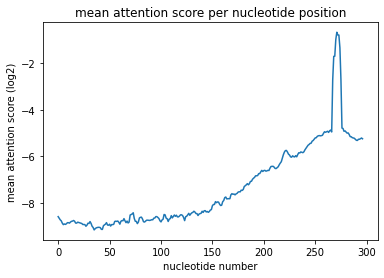

In [124]:
attention_landscapes(attention_scores)

In [121]:
def heatmapallhead(attention_scores):
    fig, ax = plt.subplots(figsize=(20, 9))
    df_attention_scores = pd.DataFrame(data = attention_scores, index = range(384))
    sb.heatmap(df_attention_scores)
    plt.title("attention map: summary heads")
    plt.ylabel("sequence")
    plt.xlabel("nucleotide number")
    plt.show()
    #the attention is focused at the +15 to + 27 region of sequence

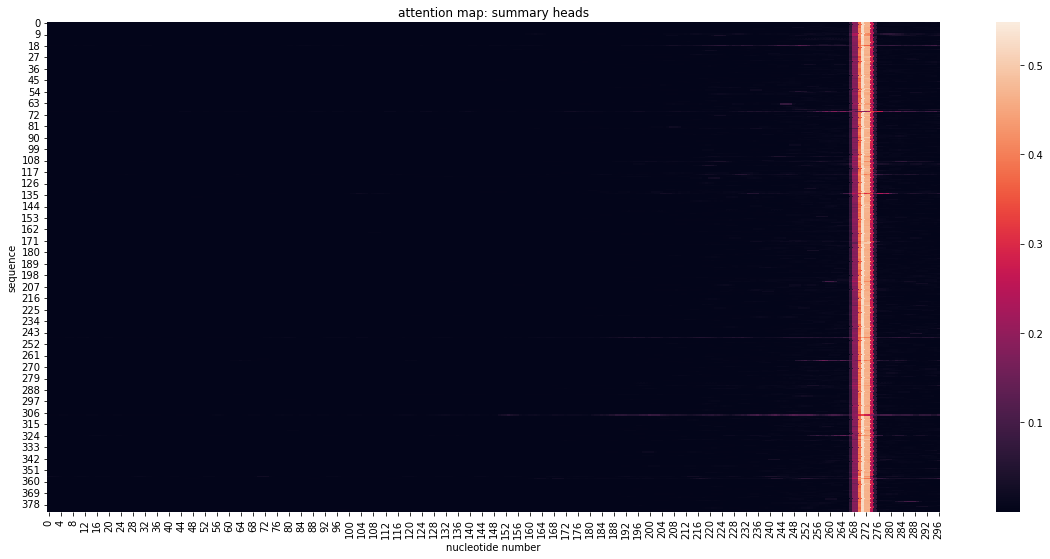

In [122]:
heatmapallhead(attention_scores)

In [116]:
def heatmapeachhead():
    for i in range(0, 12):
        filename = "att_" + str(i)
        file = np.load(filename + ".npy")
        fig, ax = plt.subplots(figsize=(10, 9))
        df_attention_score = pd.DataFrame(data = file, index = range(384))
        sb.heatmap(df_attention_score.iloc[: , 260:])
        plt.title(filename[:-len(str(i))] + str(i + 1) +" : attention_score heatmap")
        plt.ylabel("sequence")
        plt.xlabel("nucleotide number")
        plt.show()

In [ ]:
heatmapeachhead()

In [24]:
positive_seqs_kmer = list(map(lambda seq: seq2kmer(seq, 4), positive_seqs))

In [83]:
def deconstruct(pos_seqs, 
                pos_atten_scores,
                min_len = 10,
                pval_cutoff = 0.005,
                align_all_ties = True,
                window_size = 15,
                save_file_dir = "../"
                ):
    from Bio import motifs
    from Bio.Seq import Seq
    
    
    print("*** Begin motif analysis ***")
    pos_seqs = list(pos_seqs)
    
    print("* pos_seqs: {}".format(len(pos_seqs)))
    
    assert len(pos_seqs) == len(pos_atten_scores)
    
    max_seq_len = len(max(pos_seqs, key=len))
    motif_seqs = {}
    
    ## find the motif regions
    print("* Finding high attention motif regions")
    for i, score in enumerate(pos_atten_scores):
        seq_len = len(pos_seqs[i])
        score = score[0:seq_len]

        #return list of [high_att_start, high_att_end]
        motif_regions = find_high_attention(score, min_len=min_len)
        
        for motif_idx in motif_regions:
            seq = pos_seqs[i][motif_idx[0]:motif_idx[1]]
            if seq not in motif_seqs:
                motif_seqs[seq] = {'seq_idx': [i], 'atten_region_pos':[(motif_idx[0],motif_idx[1])]}
            else:
                motif_seqs[seq]['seq_idx'].append(i)
                motif_seqs[seq]['atten_region_pos'].append((motif_idx[0],motif_idx[1]))
    #above: for each positive sequence, find high attention regions and match to its respective sequence motifs

    merged_motif_seqs = merge_motifs(motif_seqs, min_len=5,
                                  align_all_ties = align_all_ties)
    
    # make fixed-length window sequences
    print("* Making fixed_length window = {}".format(window_size))
    merged_motif_seqs_fixed = make_window(merged_motif_seqs, pos_seqs, window_size=window_size)

    os.makedirs(save_file_dir, exist_ok=True)
    with open(save_file_dir+'/predicted_motifs.txt', 'w') as f:
        for motif, instances in merged_motif_seqs_fixed.items():
        # saving to files
            for seq in instances['seqs']:
                f.write(seq+'\n\n')


    return motif_seqs, merged_motif_seqs, merged_motif_seqs_fixed

In [105]:
motif_seqs_ex, merged_motif_seqs_ex, merged_motif_seqs_fixed = deconstruct(positive_seqs, attention_scores, min_len= 7, window_size= 24)

*** Begin motif analysis ***
* pos_seqs: 384
* Finding high attention motif regions
* Making fixed_length window = 24


In [106]:
print(motif_seqs_ex.keys())
motif_ex = list(motif_seqs_ex.keys())
print(len(motif_ex))
motif_ex_len = sum(len(word) for word in motif_ex) / len(motif_ex)
print(motif_ex_len)


dict_keys(['ACCAGAAGG', 'CTACCATTT', 'GCTGCCTGC', 'CCTCGGCTG', 'CGGAGACGG', 'GAGGAGACA', 'GCGATGTCG', 'GTGGCAGGGATGA', 'CCCCGTTCC', 'GCCCCGCGAGCACAGAGCCTCGCCT', 'TCTCTGCGTT', 'CATGCGTCCC', 'TCGCGAGCT', 'TCCCCCTTC', 'TGTCTGCCAGGGTCTCCGACTGTC', 'TGGCTTTGAGGG', 'CACACTGAG', 'CTCCCCGAA', 'TGGCCACTAG', 'AGCTGGCGG', 'CCTTTAAAGAAGTCAATTCAACCCTGAATGTCATAGTTAGCTACTTTCAACTGGAAGCTACAACATGGATTTATGGAATC', 'CTTTGCACA', 'CTTTGAGCG', 'TCGAGGAGG', 'GACAGACCC', 'AGCTCTGGG', 'GCTTGGCAC', 'GCTCTGCTG', 'CTCCAGGCA', 'GGACTTGTC', 'GTTGGTGTG', 'GCTGAGCCG', 'ACTCCTCTG', 'GCTGGGCAC', 'GAAGATGGC', 'TACGGCCAC', 'CAATCAGGG', 'CTGCCCGAG', 'GTCATCTGT', 'CGGCCTTGC', 'CCTCCAGTGG', 'GCTCCCGGG', 'AAAGGGACCGGAG', 'TTTTTTGGA', 'ACCGACACC', 'GCGGGCACA', 'AGAGAGAGC', 'CGCCATGAAG', 'TGAAGGGTTAGAG', 'GGTTCAAGT', 'ATAACAGCG', 'GCTGCACTT', 'TACTCGTGA', 'GACACTAGC', 'TGTCCCT', 'TGTCTTGCTAAC', 'AGCCCAGCG', 'CCATTCT', 'GGGGTTCCA', 'CTCGCGCCT', 'ATTCTAATT', 'TCCCCTCCA', 'ATGCTCCGG', 'TCTCCCGAA', 'CTGGGGGCC', 'GCAGAACTT', 'TCCAAGATG

In [107]:
merged_motif_ex = list(merged_motif_seqs_ex.keys())
print(merged_motif_ex)
print(len(merged_motif_ex))
print(sum(len(word) for word in merged_motif_ex) / len(merged_motif_ex))

['TGTCCCT', 'CCATTCT', 'CAGAATC', 'ATTACTG', 'CCTCGGCTG', 'GAGGAGACA', 'TCGCGAGCT', 'AGCTGGCGG', 'CTTTGCACA', 'GGTTCAAGT', 'AGCCCAGCG', 'ATGTGGAAC', 'CTCCAAAGG', 'CGCACCCGC', 'CAAGACGTG']
15
8.466666666666667


In [108]:
merged_motif_fixed = list(merged_motif_seqs_fixed.keys())
print(len(merged_motif_fixed))
print(sum(len(word) for word in merged_motif_fixed) / len(merged_motif_fixed))

#interesting to look at the average length decrease in these sequences

15
8.466666666666667


In [94]:
print(merged_motif_seqs_fixed)

{'TGTCCCT': {'seq_idx': [52, 2, 6, 12, 16, 27, 57, 58, 59, 65, 67, 73, 77, 78, 117, 119, 161, 166, 192, 213, 239, 258, 264, 278, 310, 327, 355, 381, 17, 139, 303, 356, 328, 202], 'atten_region_pos': [(247, 271), (259, 283), (263, 287), (259, 283), (258, 282), (264, 288), (257, 281), (260, 284), (259, 283), (263, 287), (258, 282), (258, 282), (259, 283), (261, 285), (260, 284), (233, 257), (263, 287), (261, 285), (262, 286), (261, 285), (262, 286), (261, 285), (260, 284), (260, 284), (259, 283), (259, 283), (258, 282), (259, 283), (248, 272), (259, 283), (261, 285), (250, 274), (255, 279), (264, 288)], 'seqs': ['GAGAACAGTGTCCCTGCTGTCTTG', 'CAGCAGCTGCTGCCTGCCAGAGAG', 'CCCGGCGATGTCGCTCGTGCTGCT', 'ATCCATCCTCCCCCTTCCCTCTCT', 'AAGGCCCAACTCCCCGAACCACTC', 'CCTGGACTTGTCTTGGTTCCAGAA', 'TTTTCCTCCCTCCCCTCCAACCGC', 'ACTCATGATGCTCCGGCTGCTCAG', 'GAAGCCACTCTCCCGAAACCAGAG', 'AGCCGTCCTGTCCTGGCTGCTCGC', 'GGGCCGCAGGCACCTCCTCGCCAG', 'CGGGCCGCCGTCGCTGCCGCCGCT', 'GAGTTAGCGATCCCTCAACCCCTG', 'TTGGGTCCCTTCCCTTT

In [104]:
for motif in merged_motif_seqs_fixed.keys():
    print(motif, "\n")

TGTCCCT 

CCATTCT 

CAGAATC 

ATTACTG 

CCTCGGCTG 

GAGGAGACA 

TCGCGAGCT 

AGCTGGCGG 

CTTTGCACA 

GGTTCAAGT 

AGCCCAGCG 

ATGTGGAAC 

CTCCAAAGG 

CGCACCCGC 

CAAGACGTG 



In [109]:
seqlist = []
for motif, instances in merged_motif_seqs_fixed.items():
            for seq in instances['seqs']:
                seqlist.append(seq)
print(len(seqlist))

466


In [96]:
def plotTOMTOMresult(tsvfile):
    result = pd.read_csv(tsvfile, sep='\t', header=0)
    df = pd.DataFrame(data = result, columns = ['p-value','E-value','q-value'])
    df = np.log2(df) * -1
    df.plot(kind='box')
    plt.show()

In [97]:
ls

att_0.npy   att_4.npy  attention_scores_2d.npy  positives_seq.npy
att_10.npy  att_5.npy  find_motif.py            predicted_motifs.txt
att_11.npy  att_6.npy  motif_util.py            sequences.npy
att_1.npy   att_7.npy  negative_seqs_np.npy     TOMTOM_hocomoco_v11core.tsv
att_2.npy   att_8.npy  negative_seqs.npy        TOMTOM_JASPAR_v18core.tsv
att_3.npy   att_9.npy  negatives.fa.txt


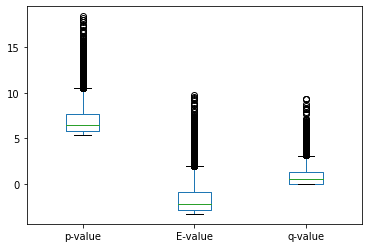

In [98]:
plotTOMTOMresult("TOMTOM_hocomoco_v11core.tsv")

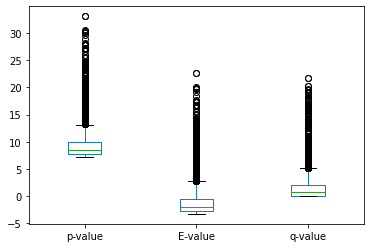

In [99]:
#compare against the DNABERT's results figs6
plotTOMTOMresult("TOMTOM_JASPAR_v18core.tsv")

In [100]:
#TODO: get to know how many motifs are found in each sequence

SyntaxError: ignored